In [41]:
import warnings
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-white')


warnings.filterwarnings("ignore")

rng = 0


In [42]:
# Loading of dataset, with data preprocessing
train_features = pd.read_csv('./data/train_features_modified.csv')
train_labels = pd.read_csv('./data/dengue_labels_train.csv')
test_features = pd.read_csv('./data/test_features_modified.csv')


In [43]:
# slice train_features, test_features and train_labels by city
# Seperate data for San Juan
sj_train_features = train_features[train_features['city'] == 'sj']
sj_train_labels = train_labels[train_labels['city'] == 'sj']

sj_train_merged = sj_train_features.merge(sj_train_labels, how='inner')

sj_test_features = test_features[test_features['city'] == 'sj']

# Separate data for Iquitos
iq_train_features = train_features[train_features['city'] == 'iq']
iq_train_labels = train_labels[train_labels['city'] == 'iq']
iq_test_features = test_features[test_features['city'] == 'iq']

# drop city column from train_features and test_features
sj_train_features.drop(['city', 'week_start_date'], axis=1, inplace=True)
sj_test_features.drop(['city', 'week_start_date'], axis=1, inplace=True)

iq_train_features.drop(['city', 'week_start_date'], axis=1, inplace=True)
iq_test_features.drop(['city', 'week_start_date'], axis=1, inplace=True)


## Feature Selection


In [44]:
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('selectkbest', SelectKBest())
])

# hyperparameter tuning for select kbest

hyperparameters = {
    'selectkbest__k': range(10, 80, 10),
    'selectkbest__score_func': [chi2]
}



In [45]:
def get_best_estimator(X, y):
    grid_search = GridSearchCV(pipeline, hyperparameters, cv=5, n_jobs=-1)
    grid_search.fit(X, y)
    return grid_search.best_estimator_


In [46]:
# select kbest features for sj_train_features and sj_train_labels
sj_train_features_kbest = pipeline.fit_transform(
    sj_train_features, sj_train_labels['total_cases'])
iq_train_features_kbest = pipeline.fit_transform(
    iq_train_features, iq_train_labels['total_cases'])


## Clustering


In [47]:
kmeans_sj = KMeans(n_clusters=5, random_state=rng).fit(sj_train_features)
clusters_sj = kmeans_sj.predict(sj_train_features)


In [48]:
kmeans_iq = KMeans(random_state=rng).fit(iq_train_features)
clusters_iq = kmeans_iq.predict(iq_train_features)


(936,)


Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'month',
       'rolling_sum_precipitation_amt_mm',
       'rolling_sum_reanalysis_sat_precip_amt_mm',
       'rolling_sum_station_precip_mm', 'rolling_avg_ndvi_ne',
       'rolling_avg_ndvi_nw', 'rolling_avg_ndvi_se', 'rolling_avg_ndvi_sw',
       'rolling_avg_reanalysis_air_temp_k',
       'rolling_avg_reanalysis_avg_temp_k',
       'rolling_avg_reanalysis_dew_point_temp_k',
       'rolling_av

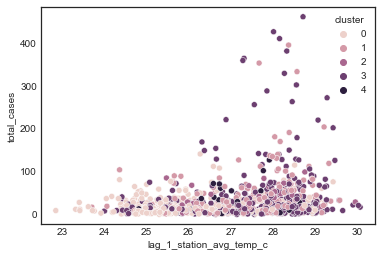

In [49]:
# after using kmeans -> use clustering to find the subset of data to train each classifier, then have an average classifier
# then use ensemble to combine the classifiers
# no need to cluster for test data

# select k best for best features

print(clusters_sj.shape)

sj_train_merged['cluster'] = kmeans_sj.labels_

sns.scatterplot(data=sj_train_merged, x="lag_1_station_avg_temp_c",
                y="total_cases", hue="cluster")

sj_train_merged.columns


In [50]:
sj_train_features.iloc[0:1, 0:-1]


,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,lag_2_reanalysis_specific_humidity_g_per_kg,lag_1_reanalysis_tdtr_k,lag_2_reanalysis_tdtr_k,lag_1_station_avg_temp_c,lag_2_station_avg_temp_c,lag_1_station_diur_temp_rng_c,lag_2_station_diur_temp_rng_c,lag_1_station_max_temp_c,lag_2_station_max_temp_c,lag_1_station_min_temp_c
0,1990,18,0.1226,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,14.012857,2.628571,2.628571,25.442857,25.442857,6.9,6.9,29.4,29.4,20.0
